In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import numpy as np
import pandas as pd 
import os
from PIL import Image 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

torch.manual_seed(45)
np.random.seed(45)

cuda:0


In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
props = torch.cuda.get_device_properties(0)
print(props)

1
NVIDIA GeForce RTX 4060
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4060', major=8, minor=9, total_memory=7796MB, multi_processor_count=24, uuid=089b23a4-ea2c-397c-2e09-e0be5e7421ac, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=24MB)


In [5]:
# Custom Dataset class modeled after Pytorch dataset. Created to avoid 'class-per-folder' 
# organization that is required by standard pytorch datasets.

# BLAME: Zebulon Mcknight *** 

class DogBreedDataset(Dataset):
    # __init__ receives a pandas dataframe of form ('id')('breed'), a directory
    # containing images, a dict of the form ('breed')(int label), and an optional
    # transform pipeline. 
    def __init__(self, label_df, img_dir, labels, transform=None): 
        self.labels_df = label_df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = labels

    # __len__ simply returns the number of samples in a dataset
    def __len__(self): 
        return len(self.labels_df)
    
    # __getitem__ takes in an index representing an entry in the dataset, it returns the img 
    # and proper class label associated with that index 
    def __getitem__(self, index): 
        row = self.labels_df.iloc[index]
        path = os.path.join(self.img_dir, row["id"]+ ".jpg")
        img = Image.open(path)
        img = img.convert("RGB")

        if self.transform: 
            img = self.transform(img)

        label = self.classes[row['breed']]

        return img, label

In [6]:
# Reading in labels for each image 
# BLAME: Minh Cao *** 
labels = pd.read_csv("data/labels.csv")
breeds = labels['breed'].unique() 

# Dict mapping 'breed' to index, model will operate on integers and we will convert back to breeds 
classes = {b: i for i, b in enumerate(breeds)}

In [7]:
# Data Transformers 

# BLAME: Zebulon Mcknight ***

train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # pytorch expects 224x224 sized images

    # These transformations are standard for introducing more randomness into the training set. 
    # These transformations haven't been tested and perfected individually, but instead
    # come as standard recommended parts of the pipeline for reducing overfitting and promoting
    # generalization 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomResizedCrop(224, scale = (0.8, 1.0)),
    transforms.RandomRotation(15), 
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3), 
    transforms.ToTensor(), 

    # Here we normalize RGB values to the mean and standard deviation of the ImageNet dataset, 
    # the set that our pretrained model was trained on. 
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # pytorch expects 224x224 sized images
    transforms.ToTensor(),

    # Here we normalize RGB values to the mean and standard deviation of the ImageNet dataset, 
    # the set that our pretrained model was trained on. 
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [8]:
# Load all data into a dataset 
# BLAME: Minh Cao *** 
dataset = DogBreedDataset(labels, "data/train", classes, train_transforms)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
test = DogBreedDataset(labels, "data/test", classes, val_transforms)
test_df = dataset.labels_df

In [10]:
num_classes = len(dataset.classes)

In [11]:
# Split data into training and validation sets stratified by class membership 
# BLAME: Viwesh Gupta
train_df, val_df = train_test_split(dataset.labels_df, 
                                    test_size=0.2, 
                                    stratify=dataset.labels_df['breed'])

#train_df.to_csv("train_split.csv", index=False)
#val_df.to_csv("val_split.csv", index=False)

In [12]:
# Load split data into independent training and validation datasets
# BLAME: Kyle Bomar ***
 
train_dataset = DogBreedDataset(
    label_df=train_df,
    img_dir ='data/train',
    labels = classes,
    transform=train_transforms
)

val_dataset = DogBreedDataset(
    label_df = val_df,
    img_dir ='data/train',
    labels = classes, 
    transform=val_transforms
)

test_dataset = DogBreedDataset(
    label_df = test_df, 
    img_dir ='data/test', 
    labels = classes, 
    transform=val_transforms
)

In [13]:
# Define our dataloaders for training and validation
# BLAME: Kyle Bomar ***

train_loader = DataLoader(
    # these variable primarily affect efficiency at fetching data
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=8, # when running on windows num_worker must equal zero, there is a well known pytorch bug forcing this 
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=8,
    pin_memory=False
)


In [14]:
# Test if the dataset itself is working
# BLAME: Viwesh Gupta ***
for i in range(3):
    try:
        x, y = train_dataset[i]
        print(f"Item {i}: Image shape = {x.shape}, Label = {y}")
    except Exception as e:
        print(f"Error at index {i}: {e}")


Item 0: Image shape = torch.Size([3, 224, 224]), Label = 68
Item 1: Image shape = torch.Size([3, 224, 224]), Label = 79
Item 2: Image shape = torch.Size([3, 224, 224]), Label = 14


In [ ]:
# DEFINING MODEL SPECIFICATIONS

# BLAME: Zebulon Mcknight and Minh Cao***

# This line represents our model. For this implementation we are 
# using resnet18 with weights pretrained on ImageNetV1. This is an
# industry standard Convolutional Neural Network designed for image
# classification. 
cnn = models.resnet18(weights="IMAGENET1K_V1")

# Here we freeze all but the last layer of the cnn, this lets us
# start from a good place for image classification but lets us
# design our own final layer for predictions. 
for param in cnn.parameters(): 
    param.requires_grad = False

# Our final layer. This resembles a 2 layer MLP (multi layer perceptron)
# That maps the hundreds or thousands of features present in the CNN 
# to the 120 outputs that we need to map to class probabilities. This layer is 
# the only layer we are training in our training loop. 
cnn.fc = nn.Sequential(
    nn.Linear(cnn.fc.in_features, 256), 
    nn.ReLU(), 
    nn.Dropout(), # Using dropout will hurt training performance, but decrease overfitting 
    nn.Linear(256, num_classes)
)

cnn=cnn.to(device)
print(cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
criterion = nn.CrossEntropyLoss() # we'll be using CrossEntropy loss 
# This is our optimizer, ADAM is similar to an improved verison of stochastic 
# gradient descent designed specifically for deep learning
optimizer = optim.Adam(cnn.fc.parameters(), lr=1e-3, weight_decay=1e-4) 

In [56]:
# TRAINING LOOP 

# BLAME: Zebulon Mcknight ***

# Our training function takes in a reference to our model, our training and validation
# loaders, a loss function, an optimizer, and a number of epochs to train for 
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, unfreeze=False, schedule=None): 
    train_losses = []
    val_losses = []
    accuracy = []

    print(f"Optimizer now has {len([p for g in optimizer.param_groups for p in g['params']])} params")

    for epoch in range(num_epochs): 
        if unfreeze == True and epoch in schedule: 
            unfreeze_layer(model, schedule[epoch])
            print(f"Unfroze {schedule[epoch]}")

            set_layers_bn_train(model, schedule[epoch])

            old_params = [p for group in optimizer.param_groups for p in group['params']]
            new_params = [p for p in model.parameters() if p.requires_grad and not any(p is x for x in old_params)]

            if new_params: 
                optimizer.add_param_group({'params': new_params, 'lr': 0.000011346083215870158}) ### UPDATE THIS BADDD BAD BADD NOOOOO 

            print(f"Optimizer now has {len([p for g in optimizer.param_groups for p in g['params']])} params")

        model.train()

        # We will track loss and accuracy for each epoch 
        running_loss = 0.0
        running_corrects = 0

        # each epoch is broken into batches of 64 images
        for inputs, labels in tqdm(train_loader): 
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs,1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss} | Accuracy: {epoch_acc}")

        train_losses.append(epoch_loss)

        # Validation loop
        # BLAME: Kyle Bomar ***
         
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad(): 
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += (preds == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss} | Accuracy: {val_acc}")

        val_losses.append(val_loss)
        accuracy.append(val_acc)

    return accuracy, train_losses, val_losses 


In [16]:
def unfreeze_layer(model, layers): 
    for name, param in model.named_parameters(): 
        if any(name.startswith(layer) for layer in layers): 
            param.requires_grad = True

        #if param.requires_grad:
            #print(f"{name} is trainable")

In [17]:
def evaluate(model, test_loader): 
    model.eval()
    predictions = []

    with torch.no_grad(): # do not use gradients when testing 
        for inputs in test_loader: 
            inputs = inputs.to(device)
            outputs = model(inputs)

            # make a prediction, convert it to numpy, and track it for submission 
            _, prediction = torch.max(outputs, 1)
            prediction = prediction.numpy()

            for sample in prediction: 
                predictions.append(sample)
            

    return np.array(predictions)

In [18]:
torch.set_num_threads(os.cpu_count())
print(os.cpu_count())

28


In [19]:
unfreezing_schedule = {
    5:["layer4"], 
    15:["layer3"], 
    20:["layer2"], 
    25:["layer1"]
}

In [ ]:
val_acc, train_loss, val_loss = train(cnn, train_loader, val_loader, criterion, optimizer, num_epochs=30, unfreeze=True, schedule=unfreezing_schedule)

Optimizer now has 4 params


100%|██████████| 128/128 [00:11<00:00, 11.18it/s]

Epoch 1/5 | Train Loss: 4.002921669731313 | Accuracy: 0.12620765561942032


Validation Loss: 2.462677225448683 | Accuracy: 0.4875305623471883
Unfroze ['layer4']
Optimizer now has 19 params


100%|██████████| 128/128 [00:17<00:00,  7.18it/s]

Epoch 2/5 | Train Loss: 2.578014586714467 | Accuracy: 0.3079368961721903


Validation Loss: 1.8123487382762882 | Accuracy: 0.47579462102689485
Unfroze ['layer3']
Optimizer now has 34 params


100%|██████████| 128/128 [00:19<00:00,  6.50it/s]

Epoch 3/5 | Train Loss: 2.270025454451552 | Accuracy: 0.3771554359789654


Validation Loss: 2.206006306366116 | Accuracy: 0.40293398533007335
Unfroze ['layer2']
Optimizer now has 49 params


100%|██████████| 128/128 [00:16<00:00,  7.72it/s]

Epoch 4/5 | Train Loss: 2.1582121364612865 | Accuracy: 0.40381558028616854


Validation Loss: 1.999330474112028 | Accuracy: 0.4469437652811736


100%|██████████| 128/128 [00:15<00:00,  8.26it/s]

Epoch 5/5 | Train Loss: 1.9002641663219522 | Accuracy: 0.46251681545799195


Validation Loss: 2.2124334790012945 | Accuracy: 0.4210268948655257


In [48]:
from datetime import datetime

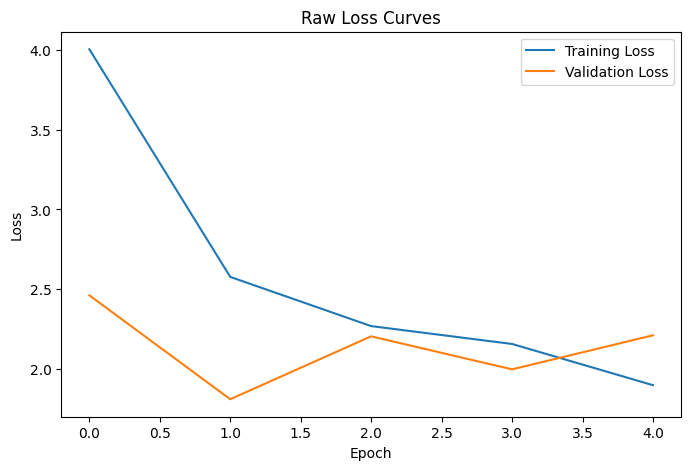

In [66]:
fig = plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Raw Loss Curves')
plt.legend()
plt.show()

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"results_figures/raw_loss_curve_{timestamp}.jpg" 

fig.savefig(filename)

In [67]:
train_loss = np.array(train_loss)
cum_train_loss = np.cumsum(train_loss)
avg_train_loss = cum_train_loss / np.arange(1, len(train_loss) + 1)

val_loss = np.array(val_loss)
cum_val_loss = np.cumsum(val_loss)
avg_val_loss = cum_val_loss / np.arange(1, len(val_loss) + 1)

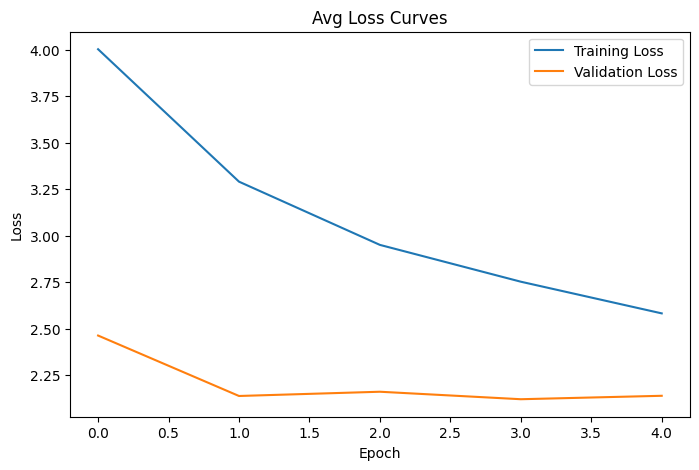

In [68]:
fig = plt.figure(figsize=(8,5))
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Avg Loss Curves')
plt.legend()
plt.show()

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"results_figures/avg_loss_curve_{timestamp}.jpg" 

fig.savefig(filename)

In [26]:
import optuna

/home/zmcknigh/cs325_final/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
def hyperparam_search(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    reg = trial.suggest_float("weight_decay", 1e-6, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.75)
    
    model = build_model(dropout)
    model.to(device)

    val_loss, val_acc = train_and_eval(model, train_loader, val_loader, lr, reg)

    print("Trial Finished")

    trial.set_user_attr("val_acc", val_acc)
    return val_loss
    

def build_model(dropout): 
    model = models.resnet18(weights="IMAGENET1K_V1")

    for param in model.parameters(): 
        param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256), 
        nn.ReLU(), 
        nn.Dropout(dropout), # Using dropout will hurt training performance, but decrease overfitting 
        nn.Linear(256, 120)
    )

    return model

def train_and_eval(model, train_loader, val_loader, lr, wd):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=lr, weight_decay=wd)

    for _ in range(10):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

    # Validation performance (metric Optuna minimizes)
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            val_loss += criterion(logits, y).item()
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

    return val_loss / len(val_loader), correct / total


In [78]:
study = optuna.create_study(direction="minimize")
study.optimize(hyperparam_search, n_trials=15)

[I 2025-11-19 11:35:03,879] A new study created in memory with name: no-name-e5f6a8ba-8f1c-4123-9596-8ac09c7baf4f
[I 2025-11-19 11:37:39,865] Trial 0 finished with value: 3.0859465152025223 and parameters: {'lr': 0.009869366534217036, 'weight_decay': 1.3304267108974096e-05, 'dropout': 0.5708948437706813}. Best is trial 0 with value: 3.0859465152025223.


Trial Finished


[I 2025-11-19 11:40:14,119] Trial 1 finished with value: 1.0058539416640997 and parameters: {'lr': 0.0011346083215870158, 'weight_decay': 0.0001245076233445863, 'dropout': 0.2917649584944907}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 11:42:49,021] Trial 2 finished with value: 3.181008644402027 and parameters: {'lr': 5.66394035437225e-05, 'weight_decay': 2.915340047902585e-05, 'dropout': 0.7394167497367325}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 11:45:29,991] Trial 3 finished with value: 1.1628041602671146 and parameters: {'lr': 0.00023501122917768947, 'weight_decay': 0.0031961593069450927, 'dropout': 0.38732033483744277}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 11:48:13,150] Trial 4 finished with value: 4.780911713838577 and parameters: {'lr': 0.033127257069619186, 'weight_decay': 2.2209601747873088e-05, 'dropout': 0.4947261462037892}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 11:50:50,524] Trial 5 finished with value: 1.256779346615076 and parameters: {'lr': 0.00017292815353035616, 'weight_decay': 2.539716167725352e-06, 'dropout': 0.4454376740895336}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 11:53:27,400] Trial 6 finished with value: 3.0266342759132385 and parameters: {'lr': 0.015223616984929472, 'weight_decay': 1.6900860428724964e-05, 'dropout': 0.05479577375880437}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 11:56:03,996] Trial 7 finished with value: 3.004001297056675 and parameters: {'lr': 0.0005147275614714288, 'weight_decay': 0.09953709862995158, 'dropout': 0.403458373096112}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 11:58:40,442] Trial 8 finished with value: 2.95250803232193 and parameters: {'lr': 7.843985362295917e-05, 'weight_decay': 0.07371108950072358, 'dropout': 0.24952599967287856}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 12:01:13,083] Trial 9 finished with value: 1.4679497331380844 and parameters: {'lr': 0.006339534636904591, 'weight_decay': 0.00010054697583992419, 'dropout': 0.29380595746827143}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 12:03:50,495] Trial 10 finished with value: 1.050593789666891 and parameters: {'lr': 0.0019547689823594845, 'weight_decay': 0.0010446892446739436, 'dropout': 0.11400569415135006}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 12:06:33,031] Trial 11 finished with value: 1.0422200188040733 and parameters: {'lr': 0.0018605721381996093, 'weight_decay': 0.0013509371545665115, 'dropout': 0.0875964581710193}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 12:09:08,964] Trial 12 finished with value: 1.1593828964978456 and parameters: {'lr': 0.0025181800389734786, 'weight_decay': 0.0025862161113696996, 'dropout': 0.19395337225463222}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 12:11:44,519] Trial 13 finished with value: 4.153891131281853 and parameters: {'lr': 1.2023215495683677e-05, 'weight_decay': 0.0004915163678828649, 'dropout': 0.017990458609697113}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


[I 2025-11-19 12:14:24,339] Trial 14 finished with value: 1.0563061479479074 and parameters: {'lr': 0.0007789129707255808, 'weight_decay': 0.00493579670747417, 'dropout': 0.14558215955491005}. Best is trial 1 with value: 1.0058539416640997.


Trial Finished


Study (Random Search) Results: 

Best: {'lr': 0.0011346083215870158, 'weight_decay': 0.0001245076233445863, 'dropout': 0.2917649584944907}

2nd: {'lr': 0.0018605721381996093, 'weight_decay': 0.0013509371545665115, 'dropout': 0.0875964581710193}

3rd: {'lr': 0.0019547689823594845, 'weight_decay': 0.0010446892446739436, 'dropout': 0.11400569415135006}

In [36]:
import itertools
from collections import namedtuple

In [ ]:
param_distributions = {
    'lr': [0.0011346083215870158, 0.0018605721381996093, 0.0019547689823594845], 
    'reg': [0.0001245076233445863, 0.0013509371545665115, 0.0010446892446739436],
    'dropout': [0.2917649584944907, 0.0875964581710193, 0.11400569415135006]
}

results = []

# For every combination of our parameters 
for lr, reg, dropout in itertools.product(
        param_distributions['lr'],
        param_distributions['reg'],
        param_distributions['dropout']): 
    
    # define and train a model with current combination 
    model = build_model(dropout)
    model.to(device)

    loss, acc = train_and_eval(model, train_loader, val_loader, lr, reg)

    # we will stoe a tuple for every combination containing accuracy and each parameter value 
    result = namedtuple('result', ['acc', 'loss', 'lr',re 'reg', 'dropout'])

    trial = result(acc, loss, lr, reg, dropout)
    results.append(trial)    

# sort the results of the grid search by validation accuracy 
results.sort(key=lambda x: x[0])
for trial in results: 
    print(f"Parameters depth:{trial.depth} layer_size:{trial.layer_size} lr:{trial.lr} reg:{trial.reg} gave accuracy of: {trial.acc[0]}")

AttributeError: 'result' object has no attribute 'depth'

In [82]:
results.sort(key=lambda x:x[0])
for trial in results: 
    print(f"Parameters lr:{trial.lr} reg:{trial.reg} dropout:{trial.dropout} gave accuracy: {trial.acc} and loss: {trial.loss}")

Parameters lr:0.0018605721381996093 reg:0.0001245076233445863 dropout:0.11400569415135006 gave accuracy: 0.6757946210268949 and loss: 1.0855473820120096
Parameters lr:0.0019547689823594845 reg:0.0010446892446739436 dropout:0.2917649584944907 gave accuracy: 0.6757946210268949 and loss: 1.0418532099574804
Parameters lr:0.0018605721381996093 reg:0.0001245076233445863 dropout:0.2917649584944907 gave accuracy: 0.6772616136919315 and loss: 1.079463716596365
Parameters lr:0.0019547689823594845 reg:0.0013509371545665115 dropout:0.11400569415135006 gave accuracy: 0.6787286063569682 and loss: 1.0689598098397255
Parameters lr:0.0019547689823594845 reg:0.0013509371545665115 dropout:0.2917649584944907 gave accuracy: 0.6792176039119805 and loss: 1.0664605423808098
Parameters lr:0.0018605721381996093 reg:0.0010446892446739436 dropout:0.11400569415135006 gave accuracy: 0.6811735941320294 and loss: 1.0479378290474415
Parameters lr:0.0019547689823594845 reg:0.0013509371545665115 dropout:0.08759645817101

Grid Search Results: 
Parameters 

lr:0.0011346083215870158 

reg:0.0013509371545665115 

dropout:0.11400569415135006 

gave accuracy: 0.702200488997555 and loss: 0.9951668437570333

In [78]:
# DEFINING IDEAL MODEL SPECIFICATIONS

# BLAME: Zebulon Mcknight and Minh Cao***

# This line represents our model. For this implementation we are 
# using resnet18 with weights pretrained on ImageNetV1. This is an
# industry standard Convolutional Neural Network designed for image
# classification. 
cnn = models.resnet18(weights="IMAGENET1K_V1")

# Here we freeze all but the last layer of the cnn, this lets us
# start from a good place for image classification but lets us
# design our own final layer for predictions. 
for param in cnn.parameters(): 
    param.requires_grad = False

for m in cnn.modules(): 
    if isinstance(m, nn.BatchNorm2d): 
        m.eval()
        if hasattr(m, "weight") and m.weight is not None: 
            m.weight.requires_grad = False
        if hasattr(m, "bias") and m.bias is not None: 
            m.bias.requires_grad = False

# Our final layer. This resembles a 2 layer MLP (multi layer perceptron)
# That maps the hundreds or thousands of features present in the CNN 
# to the 120 outputs that we need to map to class probabilities. This layer is 
# the only layer we are training in our training loop. 
cnn.fc = nn.Sequential(
    nn.Linear(cnn.fc.in_features, 256), 
    nn.ReLU(), 
    nn.Dropout(0.11400569415135006), # Using dropout will hurt training performance, but decrease overfitting 
    nn.Linear(256, num_classes)
)

cnn=cnn.to(device)
print(cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [79]:
criterion = nn.CrossEntropyLoss() # we'll be using CrossEntropy loss 
# This is our optimizer, ADAM is similar to an improved verison of stochastic 
# gradient descent designed specifically for deep learning
optimizer = optim.Adam(cnn.fc.parameters(), lr=0.0011346083215870158, weight_decay=0.0013509371545665115) 

In [80]:
unfreezing_schedule = {
    6:["layer4"], 
    12:["layer3"],
    18:["layer2"]
}

In [22]:
def set_layers_bn_train(model, layer_name_prefixes):
    """
    For layers whose names start with any prefix in layer_name_prefixes,
    set BatchNorm modules inside them to train() and make affine params trainable.
    Example layer_name_prefixes could be ['layer4'].
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm2d):
            # find parent module name that contains this BN
            # named_modules gives hierarchical names like 'layer4.1.bn2'
            if any(name.startswith(prefix) for prefix in layer_name_prefixes):
                module.train()
                if hasattr(module, "weight") and module.weight is not None:
                    module.weight.requires_grad = True
                if hasattr(module, "bias") and module.bias is not None:
                    module.bias.requires_grad = True

In [81]:
val_acc, train_loss, val_loss = train(cnn, train_loader, val_loader, criterion, optimizer, num_epochs=25, unfreeze=True, schedule=unfreezing_schedule)

Optimizer now has 4 params


100%|██████████| 128/128 [00:18<00:00,  7.03it/s]

Epoch 1/25 | Train Loss: 3.3952032706550037 | Accuracy: 0.246422893481717


Validation Loss: 1.8261772291584528 | Accuracy: 0.5193154034229829


100%|██████████| 128/128 [00:20<00:00,  6.13it/s]

Epoch 2/25 | Train Loss: 1.771545761763153 | Accuracy: 0.5157148098324569


Validation Loss: 1.3136819170856242 | Accuracy: 0.6259168704156479


100%|██████████| 128/128 [00:13<00:00,  9.35it/s]

Epoch 3/25 | Train Loss: 1.4674769956324698 | Accuracy: 0.5817536994007583


Validation Loss: 1.1570801055810271 | Accuracy: 0.6577017114914425


100%|██████████| 128/128 [00:13<00:00,  9.84it/s]

Epoch 4/25 | Train Loss: 1.3414248392811408 | Accuracy: 0.6114711997064938


Validation Loss: 1.0834646156772716 | Accuracy: 0.6753056234718826


100%|██████████| 128/128 [00:19<00:00,  6.59it/s]

Epoch 5/25 | Train Loss: 1.2464995872745512 | Accuracy: 0.632016632016632


Validation Loss: 1.0667564014350872 | Accuracy: 0.6797066014669927


100%|██████████| 128/128 [00:16<00:00,  7.61it/s]

Epoch 6/25 | Train Loss: 1.1917832778429394 | Accuracy: 0.642656230891525


Validation Loss: 1.0323571606486817 | Accuracy: 0.6968215158924206
Unfroze ['layer4']
Optimizer now has 19 params


100%|██████████| 128/128 [00:13<00:00,  9.84it/s]

Epoch 7/25 | Train Loss: 1.1487515688496492 | Accuracy: 0.6568423627247156


Validation Loss: 0.9948550518392643 | Accuracy: 0.702200488997555


100%|██████████| 128/128 [00:16<00:00,  7.91it/s]

Epoch 8/25 | Train Loss: 1.0629924581017924 | Accuracy: 0.6831356243120948


Validation Loss: 0.9916196765118531 | Accuracy: 0.7080684596577017


100%|██████████| 128/128 [00:20<00:00,  6.39it/s]

Epoch 9/25 | Train Loss: 0.9775354880873754 | Accuracy: 0.7014797603032897


Validation Loss: 0.9821717252066783 | Accuracy: 0.7100244498777506


100%|██████████| 128/128 [00:13<00:00,  9.19it/s]

Epoch 10/25 | Train Loss: 0.9500367981567933 | Accuracy: 0.7100403570991807


Validation Loss: 1.006065732809034 | Accuracy: 0.7100244498777506


100%|██████████| 128/128 [00:14<00:00,  9.10it/s]

Epoch 11/25 | Train Loss: 0.9014506672419151 | Accuracy: 0.720435367494191


Validation Loss: 0.9689758492273923 | Accuracy: 0.7256723716381418


100%|██████████| 128/128 [00:18<00:00,  6.89it/s]

Epoch 12/25 | Train Loss: 0.8423471093702626 | Accuracy: 0.741714565243977


Validation Loss: 0.9716443041426045 | Accuracy: 0.7070904645476772
Unfroze ['layer3']
Optimizer now has 34 params


100%|██████████| 128/128 [00:19<00:00,  6.73it/s]

Epoch 13/25 | Train Loss: 0.8156445558444058 | Accuracy: 0.7451388039623333


Validation Loss: 0.9512263295994411 | Accuracy: 0.7154034229828851


100%|██████████| 128/128 [00:14<00:00,  8.60it/s]

Epoch 14/25 | Train Loss: 0.7412282879842119 | Accuracy: 0.7611593493946435


Validation Loss: 0.9739291377638838 | Accuracy: 0.7154034229828851


100%|██████████| 128/128 [00:14<00:00,  8.71it/s]

Epoch 15/25 | Train Loss: 0.7063192495641374 | Accuracy: 0.7744894215482451


Validation Loss: 0.9552882844195097 | Accuracy: 0.7188264058679706


100%|██████████| 128/128 [00:18<00:00,  6.96it/s]

Epoch 16/25 | Train Loss: 0.6672740569831369 | Accuracy: 0.7894093188210836


Validation Loss: 0.9437263762163941 | Accuracy: 0.7251833740831296


100%|██████████| 128/128 [00:18<00:00,  6.92it/s]

Epoch 17/25 | Train Loss: 0.6213633355905421 | Accuracy: 0.8034731564143329


Validation Loss: 0.9231076979986904 | Accuracy: 0.7276283618581907


100%|██████████| 128/128 [00:14<00:00,  8.71it/s]


Epoch 18/25 | Train Loss: 0.607847495141437 | Accuracy: 0.803106273694509
Validation Loss: 0.9639107191475214 | Accuracy: 0.7149144254278729
Unfroze ['layer2']
Optimizer now has 49 params


100%|██████████| 128/128 [00:16<00:00,  7.74it/s]

Epoch 19/25 | Train Loss: 0.5655179880235982 | Accuracy: 0.8196159960865843


Validation Loss: 0.9928252702820272 | Accuracy: 0.7158924205378973


100%|██████████| 128/128 [00:17<00:00,  7.34it/s]

Epoch 20/25 | Train Loss: 0.5253329850415285 | Accuracy: 0.8311116546410664


Validation Loss: 0.9744359625872306 | Accuracy: 0.721760391198044


100%|██████████| 128/128 [00:19<00:00,  6.49it/s]

Epoch 21/25 | Train Loss: 0.5010421226452364 | Accuracy: 0.838693897517427


Validation Loss: 0.9536468305331279 | Accuracy: 0.7378973105134474


100%|██████████| 128/128 [00:17<00:00,  7.23it/s]

Epoch 22/25 | Train Loss: 0.47233449590152204 | Accuracy: 0.8461538461538461


Validation Loss: 0.9654160971163538 | Accuracy: 0.7202933985330073


100%|██████████| 128/128 [00:16<00:00,  7.81it/s]

Epoch 23/25 | Train Loss: 0.44654582418438504 | Accuracy: 0.8605845664669194


Validation Loss: 0.9806452372837766 | Accuracy: 0.7222493887530562


100%|██████████| 128/128 [00:16<00:00,  7.67it/s]

Epoch 24/25 | Train Loss: 0.43482676564269446 | Accuracy: 0.8570380335086217


Validation Loss: 0.9875545325372505 | Accuracy: 0.717359413202934


100%|██████████| 128/128 [00:19<00:00,  6.70it/s]

Epoch 25/25 | Train Loss: 0.4063972254407075 | Accuracy: 0.871468753821695


Validation Loss: 0.9720357551842855 | Accuracy: 0.7286063569682152


best acc: 6, 12, 18 (25) 0.7286063569682152


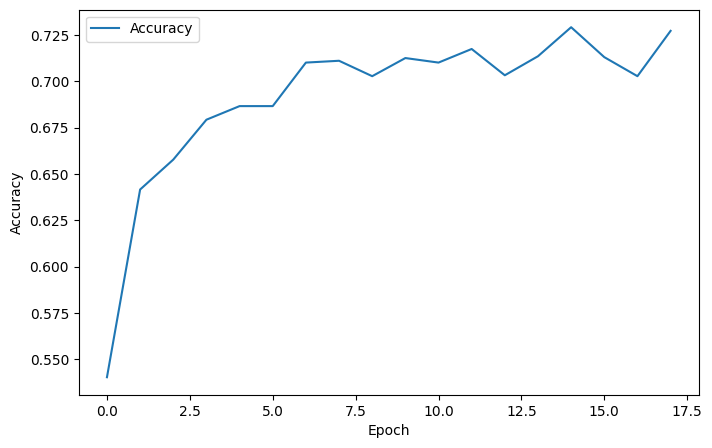

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.plot(val_acc, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

fig.savefig("6_12_18_(25)accuracy.jpg")

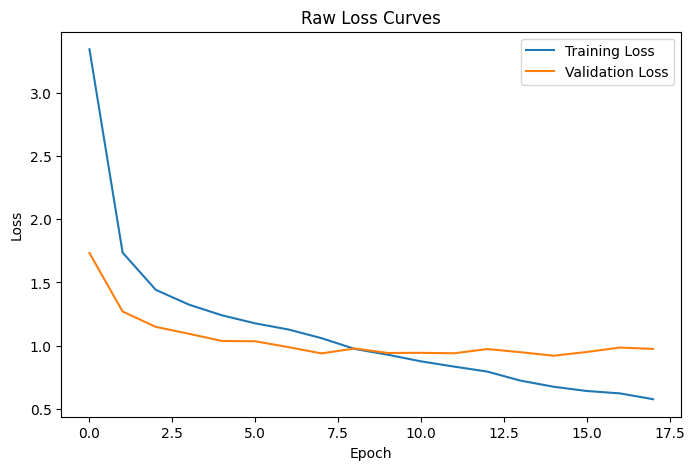

In [75]:
fig = plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Raw Loss Curves')
plt.legend()
plt.show()

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"results_figures/raw_loss_curve_{timestamp}.jpg" 

fig.savefig(filename)

In [76]:
train_loss = np.array(train_loss)
cum_train_loss = np.cumsum(train_loss)
avg_train_loss = cum_train_loss / np.arange(1, len(train_loss) + 1)

val_loss = np.array(val_loss)
cum_val_loss = np.cumsum(val_loss)
avg_val_loss = cum_val_loss / np.arange(1, len(val_loss) + 1)

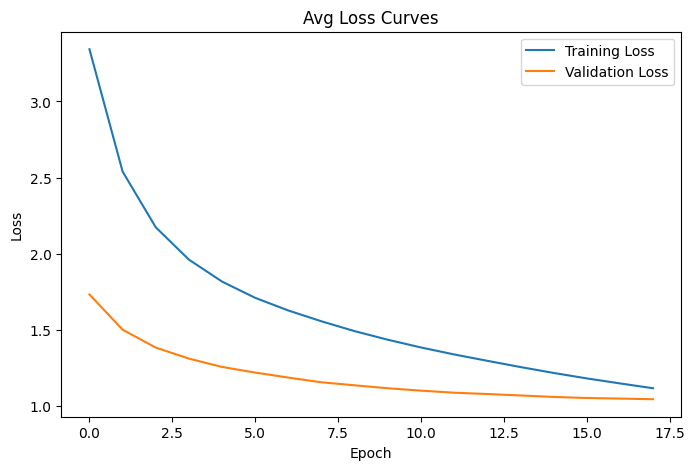

In [77]:
fig = plt.figure(figsize=(8,5))
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Avg Loss Curves')
plt.legend()
plt.show()

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"results_figures/avg_loss_curve_{timestamp}.jpg" 

fig.savefig(filename)

In [53]:
small = [next(iter(train_loader)) for _ in range(1)][0]
x,y = small; x,y = x.to(device), y.to(device)
for i in range(100):
    optimizer.zero_grad()
    loss = criterion(cnn(x), y)
    loss.backward()
    optimizer.step()
    if i%10==0: print(i, loss.item())


0 0.9070981740951538
10 0.014366413466632366
20 0.001882287673652172
30 0.000586625887081027
40 0.00029901822563260794
50 0.00021281061344780028
60 0.00017601177387405187
70 0.0001566111168358475
80 0.0001444972731405869
90 0.0001362933253403753


In [54]:
x,y = next(iter(train_loader))
x,y = x.to(device), y.to(device)
optimizer.zero_grad()
loss = criterion(cnn(x), y)
loss.backward()
missing = [n for n,p in cnn.named_parameters() if p.requires_grad and p.grad is None]
print("params with missing grad:", missing[:10])


params with missing grad: []


In [55]:
from pprint import pprint

def inspect_optimizer(optimizer, model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    tracked = sum(p.numel() for g in optimizer.param_groups for p in g['params'])
    print("trainable params:", trainable, "tracked by optimizer:", tracked)
    for i,g in enumerate(optimizer.param_groups):
        n = sum(p.numel() for p in g['params'])
        print(f"group {i}: params={n}, lr={g.get('lr')}, weight_decay={g.get('weight_decay')}")
    print("Sample trainable param names:")
    for name,p in model.named_parameters():
        if p.requires_grad:
            print(name, p.shape); break

inspect_optimizer(optimizer, cnn)


trainable params: 8555896 tracked by optimizer: 8555896
group 0: params=162168, lr=0.0011346083215870158, weight_decay=0.0013509371545665115
group 1: params=8393728, lr=0.00011346083215870158, weight_decay=0.0013509371545665115
Sample trainable param names:
layer4.0.conv1.weight torch.Size([512, 256, 3, 3])


In [ ]:
model_state = cnn.state_dict()

torch.save(model_state, "model_2.0")

In [ ]:
# load trained model from storage
state_dict = torch.load("model_1.0", map_location=device)
cnn.load_state_dict(state_dict)

<All keys matched successfully>